### Cell Description
Install the `google.colab` package required for Colab workflow (may show error locally if not running on Colab).


In [ ]:
!pip install google.colab

### Cell Description
Upload `kaggle.json` file from your device to the runtime environment using Colab's upload tool.


In [ ]:
from google.colab import files
files.upload()   # kaggle.json

### Cell Description
Setup Kaggle credentials: create credentials directory, copy `kaggle.json` to correct path, and set required permissions for Kaggle API access.


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


### Cell Description
Download the ASL alphabet dataset from Kaggle and extract it to the `asl_alphabe` directory for training data.


In [6]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip -d asl_alphabe

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Cell Description
Install MediaPipe library for hand landmark detection and pose estimation capabilities.


*Key_Points*

### Cell Description
Import all required libraries: OpenCV for image processing, NumPy for arrays, MediaPipe for hand detection, Matplotlib for plotting, TensorFlow for deep learning, and other utilities for data processing.


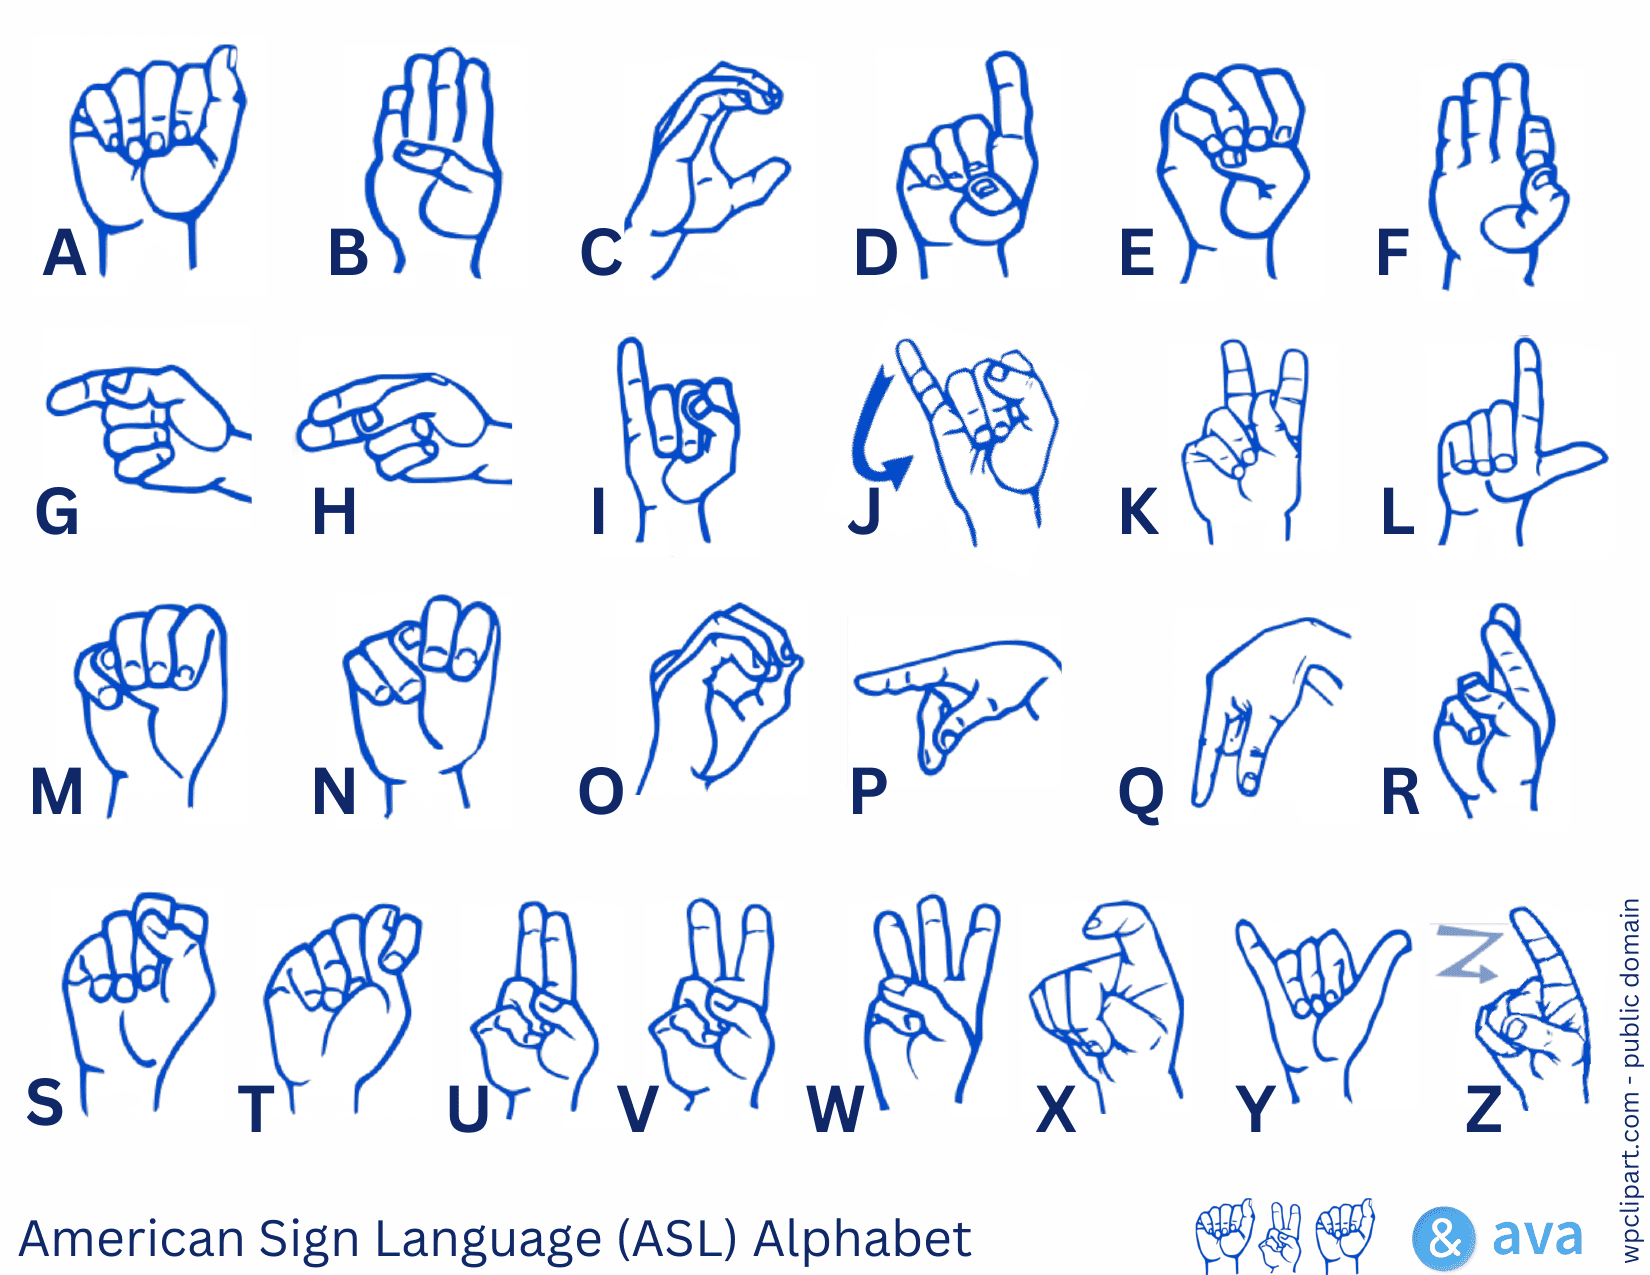

### Cell Description
Split the data into training and validation sets, then train the neural network model for 20 epochs with batch size 32.


In [ ]:
!pip install mediapipe

: 

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random
import os
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



### Cell Description
Install Streamlit and Streamlit WebRTC for creating a web-based real-time sign language recognition application.


In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)


### Cell Description
Real-time sign language recognition: Load the trained model, initialize MediaPipe for hand detection, capture video from webcam, extract hand landmarks, and predict sign language gestures in real-time.


In [ ]:
data_dir = "/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train"
classes = os.listdir(data_dir)
print(classes)

['V', 'H', 'Q', 'A', 'K', 'Y', 'C', 'nothing', 'Z', 'P', 'W', 'G', 'F', 'U', 'space', 'R', 'L', 'J', 'T', 'I', 'B', 'del', 'E', 'N', 'X', 'M', 'O', 'D', 'S']


In [ ]:
X = []
y = []

for label in classes:
    folder_path = os.path.join(data_dir, label)
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            X.append(keypoints)
            y.append(label)


100%|██████████| 3000/3000 [01:22<00:00, 36.24it/s]


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
X = np.array(X)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(classes)

model = models.Sequential([
    layers.Input(shape=(63,)),      # 21 joint * 3
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333 (71.61 KB)

 Trainable params: 18,333 (71.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3544 - loss: 2.2249 - val_accuracy: 0.9196 - val_loss: 0.4187
Epoch 2/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8328 - loss: 0.5470 - val_accuracy: 0.9543 - val_loss: 0.2507
Epoch 3/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8910 - loss: 0.3671 - val_accuracy: 0.9618 - val_loss: 0.1763
Epoch 4/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9173 - loss: 0.2883 - val_accuracy: 0.9605 - val_loss: 0.1627
Epoch 5/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9265 - loss: 0.2479 - val_accuracy: 0.9556 - val_loss: 0.1511
Epoch 6/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9313 - loss: 0.2360 - val_accuracy: 0.9632 - val_loss: 0.1338
Epoch 7/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9377 - loss: 0.2120 - val_accuracy: 0.9711 - val_loss: 0.1200
Epoch 8/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9401 - loss: 0.2032 -

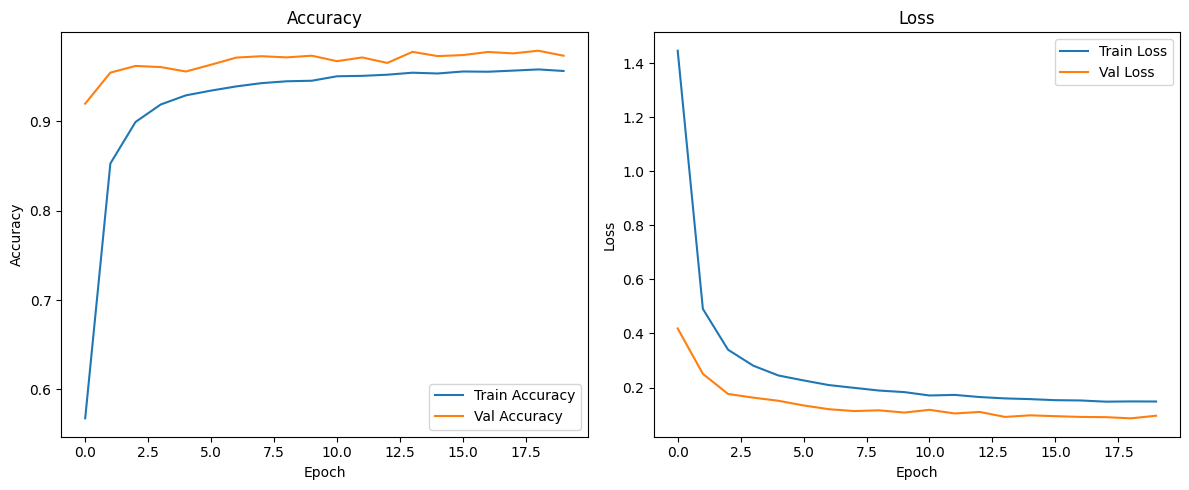

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy subplot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss subplot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = 64
num_classes = 29
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% 
)

train_generator = train_datagen.flow_from_directory(
    '/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train',  #change 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

model = load_model("asl_keypoints_model.h5")

class_name = random.choice(list(train_generator.class_indices.keys()))
img_name = random.choice(os.listdir(os.path.join("/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train", class_name)))
img_path = os.path.join("/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train", class_name, img_name)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = hands.process(img_rgb)

if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]

    img_plot = img_rgb.copy()
    mp_drawing.draw_landmarks(img_plot, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    plt.figure(figsize=(6,6))
    plt.imshow(img_plot)
    plt.axis("off")
    plt.show()

    keypoints = []
    for lm in hand_landmarks.landmark:
        keypoints.extend([lm.x, lm.y, lm.z])
    keypoints = np.array(keypoints).reshape(1, 63)
    model = load_model("asl_keypoints_model.h5")
    pred = model.predict(keypoints)
    pred_class = np.argmax(pred)

    class_indices = train_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    pred_letter = inv_class_indices[pred_class]

    print("Predicted letter:", pred_letter,"true :",class_name )
else:
    print("No hand detected")


### Cell Description
Save the trained model to disk as an HDF5 file for later use in real-time prediction.

In [ ]:
model.save("asl_keypoints_model.h5")


In [ ]:
!pip install streamlit streamlit_webrtc

#sample app

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

model = tf.keras.models.load_model("asl_keypoints_model.h5")
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z","del","nothing","space"]

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])

            keypoints = np.array(keypoints).reshape(1, 63)

            pred = model.predict(keypoints)
            pred_class = np.argmax(pred)

            cv2.putText(frame, f"Class: {class_names[pred_class]}", (20, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("ASL Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


***FINSH***